In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/Users/ferran/PhD/yaleCollab


In this notebook we will compute a wavelet dictionary on the NicheNet KG and KGE

# Data ingestion

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Looking for R's HOME:
    Environment variable R_HOME: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Calling `R RHOME`: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/:/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/ferran/miniconda3/envs/collabLite/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/ferran/miniconda3/envs/collabLite/lib', '/Users/ferran/miniconda3/envs/collabLite/lib/R/lib', '/Users/ferran/miniconda3/envs/collabLite/lib']
  extra_compile_args:
  []
  extra_lin

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/Users/ferran/PhD/yaleCollab/data"


In [7]:
%%R -o dRnaSeq,dPHATEcoord

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


View Object and metadata

AxisArrays with keys: 
Before filtering we have 20867 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

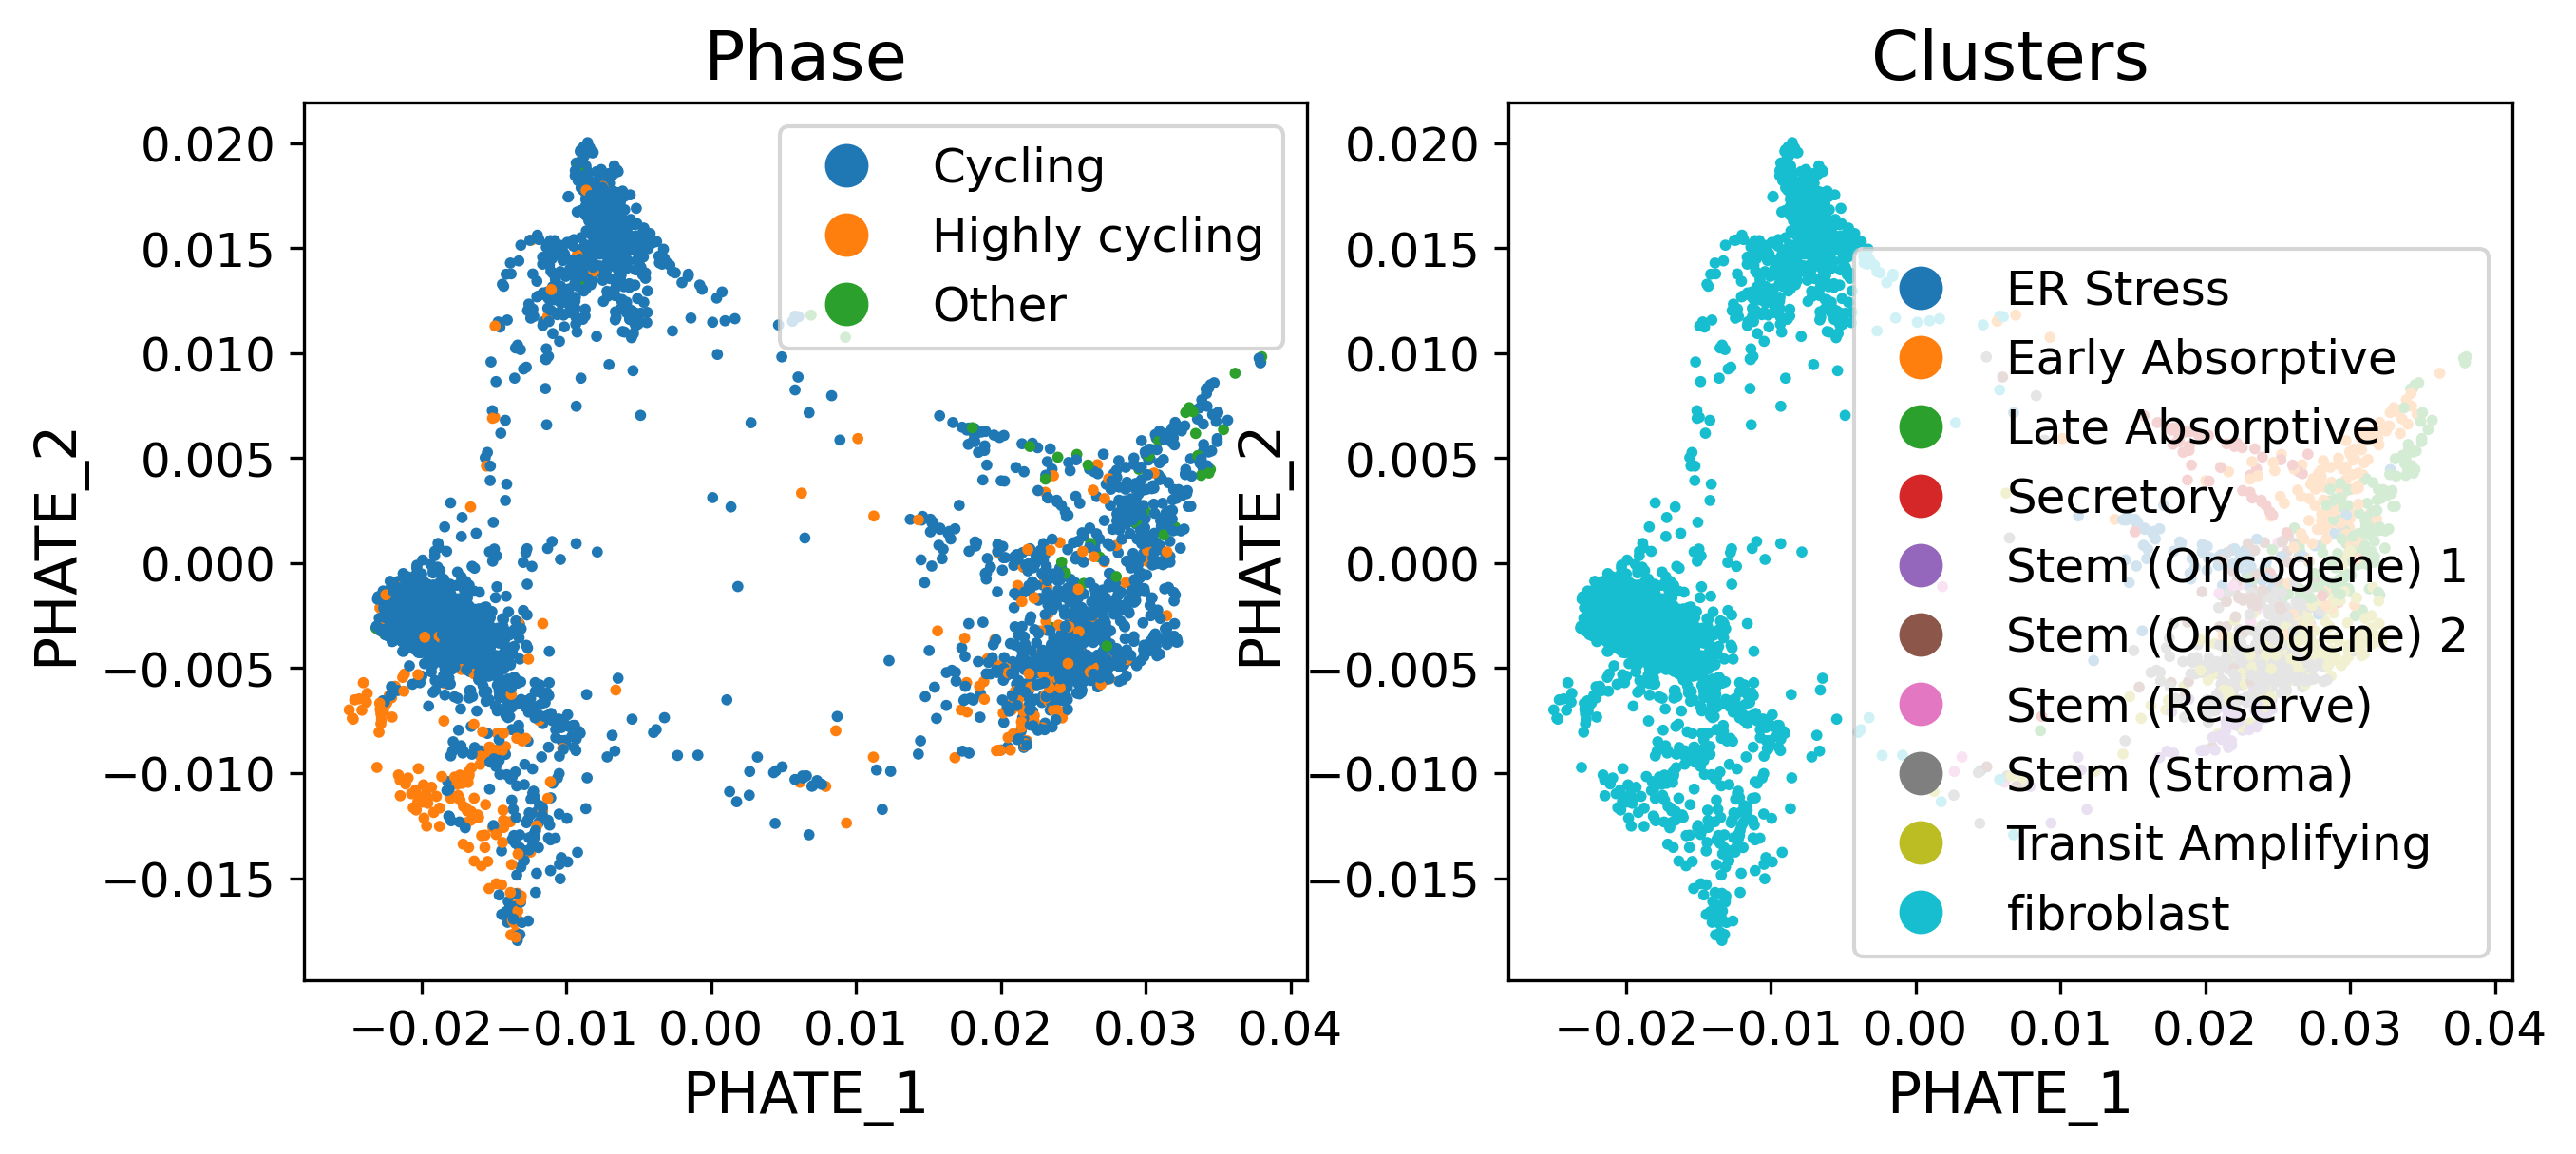

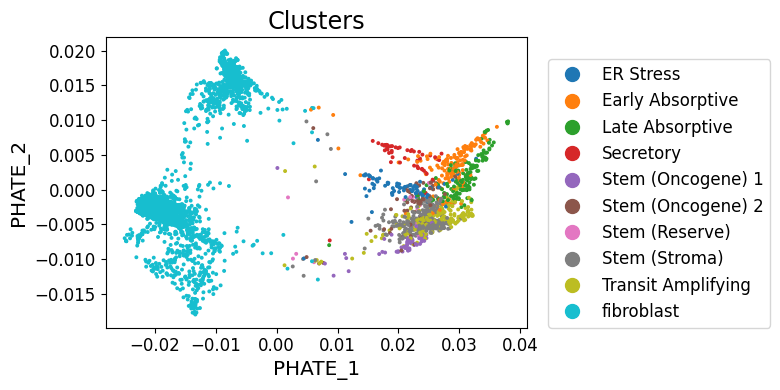

In [8]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

### Process data to human

Convert SEQ data to HGNC symbols

In [9]:
from biomart import BiomartServer

server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True
mart = server.datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 107'] Fetching datasets
[BiomartDatabase:'Mouse strains 107'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 107'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 107'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 107'] Fetching datasets
[BiomartDataset:'mmusculus_gene_ensembl'] Searching using following params:
{'attributes': ['external_gene_name', 'hsapiens_homolog_associated_gene_name']}
[BiomartDataset:'mmusculus_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="mmusculus_gene_ensembl" interface="default"><Attribute name="external_

In [10]:
adRnaSeq = dRnaSeq
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1300017J02Rik,1500009C09Rik,1700015F17Rik,1700020D05Rik,1700030C10Rik.1,1810026B05Rik,2010300C02Rik,...,ZYX,ZZEF1,ZZZ3,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.0,0.0,0.0,0.0,0.0,0.657148,0.0,...,0.657148,0.657148,0.657148,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.0,0.0,0.0,0.0,0.0,0.498218,0.0,...,0.498218,0.000000,0.829238,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.0,0.0,0.0,0.0,0.0,0.787727,0.0,...,1.028759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.0,0.0,0.0,0.0,0.0,0.402734,0.0,...,0.000000,0.221506,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.695505,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,1.071710,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.0,0.0,0.0,0.0,0.0,1.015210,0.0,...,0.461624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.0,0.0,0.0,0.0,0.0,0.615369,0.0,...,0.993504,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


## Load KG data

In [11]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
5444497,R-HSA-6798695,pathway,SIGLEC5
5444498,R-HSA-1181150,pathway,TDGF1P3
5444499,R-HSA-1433617,pathway,TDGF1P3
5444500,R-HSA-3295583,pathway,TRPM5


In [12]:
modelKGE = "KGnn_50_unstratified_stopped_transe"

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGnn_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values()).drop(index=["nan"])
dKGEnn_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A1BG,-0.114693,-0.062056,-0.142618,-0.018786,0.079787,0.151638,0.154332,-0.166625,-0.164315,0.150550,...,0.110171,0.162007,0.136376,0.098658,0.172536,0.010266,-0.002167,0.260938,-0.156283,0.223170
A1BG-AS1,0.124340,-0.244321,0.261028,0.177759,0.052111,-0.206777,-0.068553,0.004152,-0.151796,0.048616,...,0.026584,-0.064389,0.186161,0.029930,0.043194,-0.230858,0.020652,-0.079490,-0.100852,-0.110040
A1CF,0.012249,0.097411,0.089748,-0.107028,0.042079,-0.015802,-0.015080,-0.035531,-0.108423,0.396735,...,0.109560,-0.146671,0.138407,0.118278,-0.090030,-0.198067,-0.064056,0.112160,-0.157560,0.070585
A2M,-0.076020,0.167864,-0.133910,-0.082698,0.086467,-0.096204,-0.068033,-0.012295,-0.197465,-0.067780,...,0.217745,0.121485,-0.044373,0.006619,0.188977,-0.075680,-0.122628,0.149013,-0.203135,0.045033
A2M-AS1,-0.124042,-0.071744,0.190024,0.210376,-0.199619,-0.146263,-0.201290,-0.032545,-0.092695,0.039749,...,-0.011503,0.263200,-0.154127,0.032356,-0.221216,-0.127091,-0.050592,-0.162741,0.066823,0.046689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.157768,0.169630,0.128678,-0.037648,0.034921,0.087765,-0.117535,-0.170905,0.005733,0.032774,...,0.107611,0.173982,0.080564,0.081189,-0.287715,-0.076782,-0.078907,-0.008748,-0.215508,-0.271883
ZYG11B,0.154281,0.013954,-0.161645,-0.170701,0.077110,0.007194,0.163640,0.013357,0.084101,-0.117073,...,0.051953,-0.137357,-0.201208,0.120000,-0.147011,0.176326,-0.140640,0.019583,-0.134760,-0.269244
ZYX,0.168261,0.047865,-0.021720,-0.076904,-0.110663,0.096434,0.134658,-0.113244,0.069367,0.069998,...,0.089988,-0.037320,-0.318342,0.089743,0.215972,0.183160,-0.249219,0.011088,0.176135,-0.244414
ZZEF1,-0.587509,0.074710,-0.146124,0.098394,-0.006699,0.052911,-0.004144,-0.310832,0.171271,0.067289,...,-0.024145,0.191872,0.026109,0.103047,0.075540,0.109647,0.108737,-0.114406,-0.031095,-0.060478


## Match genes in KG and scRNA-seq

In [13]:
dGenesSeq = list(dRnaSeq.columns)

dKGnn_filt = dKGnn.loc[dKGnn[0].isin(dGenesSeq) & dKGnn[2].isin(dGenesSeq)]
print(dKGnn.shape,dKGnn_filt.shape)

dKGEnn_50filt = dKGEnn_50.loc[dKGEnn_50.index.isin(dGenesSeq)]
print(dKGEnn_50.shape,dKGEnn_50filt.shape)

(5444502, 3) (3722338, 3)
(27619, 50) (13265, 50)


In [14]:
dRnaSeq_filt = dRnaSeq.loc[:,dRnaSeq.columns.isin(dKGEnn_50filt.index)]
print(len(dRnaSeq_filt.columns))
print(dRnaSeq_filt.columns.nunique())

13265
13265


In [15]:
del dKGnn,dKGEnn_50,dRnaSeq,dGenesSeq

### Explore filtered KGnn

In [16]:
G = networkx.from_pandas_edgelist(dKGnn_filt, source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
    networkx.number_of_isolates(G))
print("The graph is connected:",
    networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_15578/440223923.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 13153 nodes and 2846334 edges, with a density of 0.032907829303741865
We have this many isolates:  0
The graph is connected: True


No need to work with any components.NOte however that the number of entities 
does not match the number of nodes in the networkx object.

In [17]:
dKGnn_filt = dKGnn_filt.loc[dKGnn_filt[0].isin(G.nodes()) & dKGnn_filt[2].isin(G.nodes())]
dKGEnn_50filt = dKGEnn_50filt.loc[dKGEnn_50filt.index.isin(G.nodes())]
dRnaSeq_filt = dRnaSeq_filt.loc[:,dRnaSeq_filt.columns.isin(G.nodes())]
print(dKGnn_filt.shape, dKGEnn_50filt.shape, dRnaSeq_filt.shape)

(3722338, 3) (13153, 50) (3698, 13153)


# Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [18]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                      )

In [19]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq_filt
)
del magic_op
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 13153 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 1.79 seconds.
  Running MAGIC with `solver='exact'` on 13153-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.61 seconds.
Calculated MAGIC in 3.50 seconds.


,A1CF,A3GALT2,A4GALT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
WT__AAACCCACAGCTTCCT-1,0.000000,0.000258,0.586844,0.082032,0.067412,0.000000,0.091716,0.171168,0.276099,0.845424,...,0.112934,0.031459,0.050325,0.005693,0.380573,0.084830,0.089778,0.407534,0.099494,0.332882
WT__AAACCCAGTTCGAGCC-1,0.000000,0.000293,0.530184,0.114710,0.070677,0.000000,0.120770,0.184213,0.269633,0.874107,...,0.102266,0.030991,0.048876,0.044092,0.377858,0.086941,0.072191,0.434850,0.082012,0.312369
WT__AAACGAAAGAAGGATG-1,0.000000,0.000196,0.510759,0.078966,0.088983,0.000000,0.093565,0.165490,0.258927,0.893344,...,0.110644,0.016039,0.074536,0.004164,0.419534,0.095236,0.082117,0.444442,0.071228,0.264416
WT__AAACGAAAGGAAAGGT-1,0.189307,0.000000,0.001601,0.010449,0.030600,0.005708,0.130948,0.078329,0.416694,0.343990,...,0.084368,0.000505,0.011398,0.000000,0.263221,0.028233,0.070872,0.181802,0.125928,0.059276
WT__AAACGAAAGTTAACGA-1,0.029956,0.000000,0.005313,0.046453,0.096456,0.002455,0.097354,0.057823,0.363085,0.522234,...,0.063952,0.014048,0.030114,0.003331,0.570999,0.030025,0.025935,0.163564,0.085023,0.076836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.002993,0.000000,0.007482,0.044822,0.042040,0.000000,0.091749,0.157544,0.108644,0.382272,...,0.183184,0.002110,0.016963,0.000394,0.723944,0.109817,0.024169,0.126772,0.089269,0.084930
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.000121,0.610711,0.092046,0.078171,0.000000,0.142338,0.229774,0.221397,0.784325,...,0.150878,0.012047,0.072075,0.009613,0.361861,0.084367,0.139928,0.433773,0.090069,0.336890
WT__TTTGTTGTCGCTTGAA-1,0.080684,0.000000,0.010457,0.030102,0.116927,0.002579,0.095327,0.069841,0.539359,0.458472,...,0.097674,0.004797,0.018480,0.000025,0.379978,0.028804,0.053125,0.124899,0.114794,0.069261
WT__TTTGTTGTCTGAATCG-1,0.000331,0.000521,0.618677,0.068676,0.063451,0.000103,0.091032,0.196399,0.448428,0.937587,...,0.079147,0.025018,0.075428,0.002502,0.749846,0.045104,0.074829,0.555603,0.119173,0.176992


View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [20]:
print(mouse2human["Cd44"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Epcam"] in dMagicRnaSeq.columns)

print(mouse2human["Pdgfra"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Thy1"] in dMagicRnaSeq.columns)

True
True
True
True
True
True


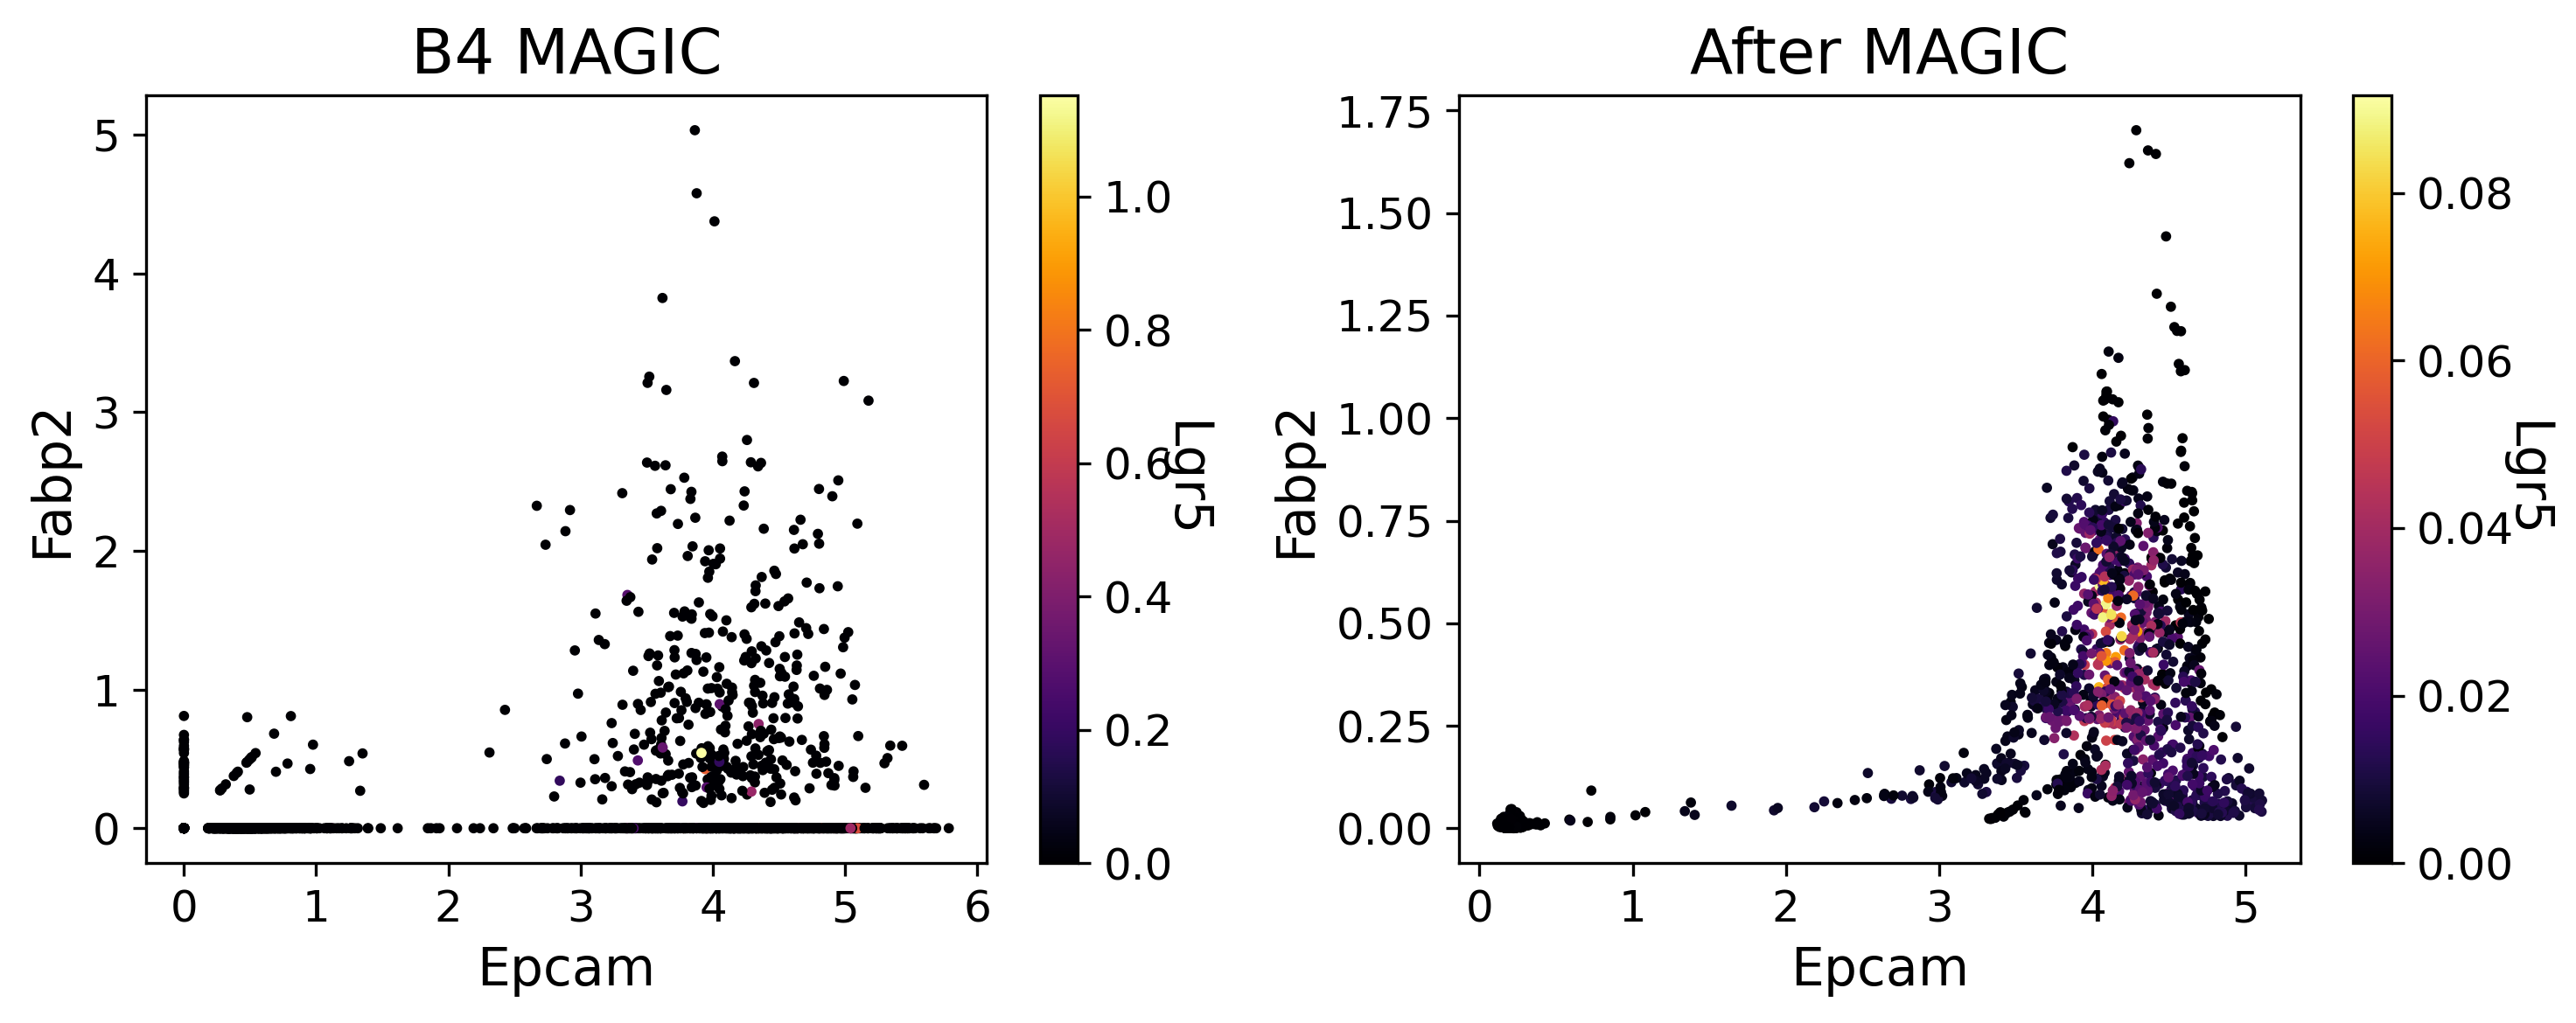

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Epcam"]], y=dRnaSeq_filt[mouse2human["Fabp2"]], 
    c=dRnaSeq_filt[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Epcam"]], y=dMagicRnaSeq[mouse2human["Fabp2"]], 
    c=dMagicRnaSeq[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

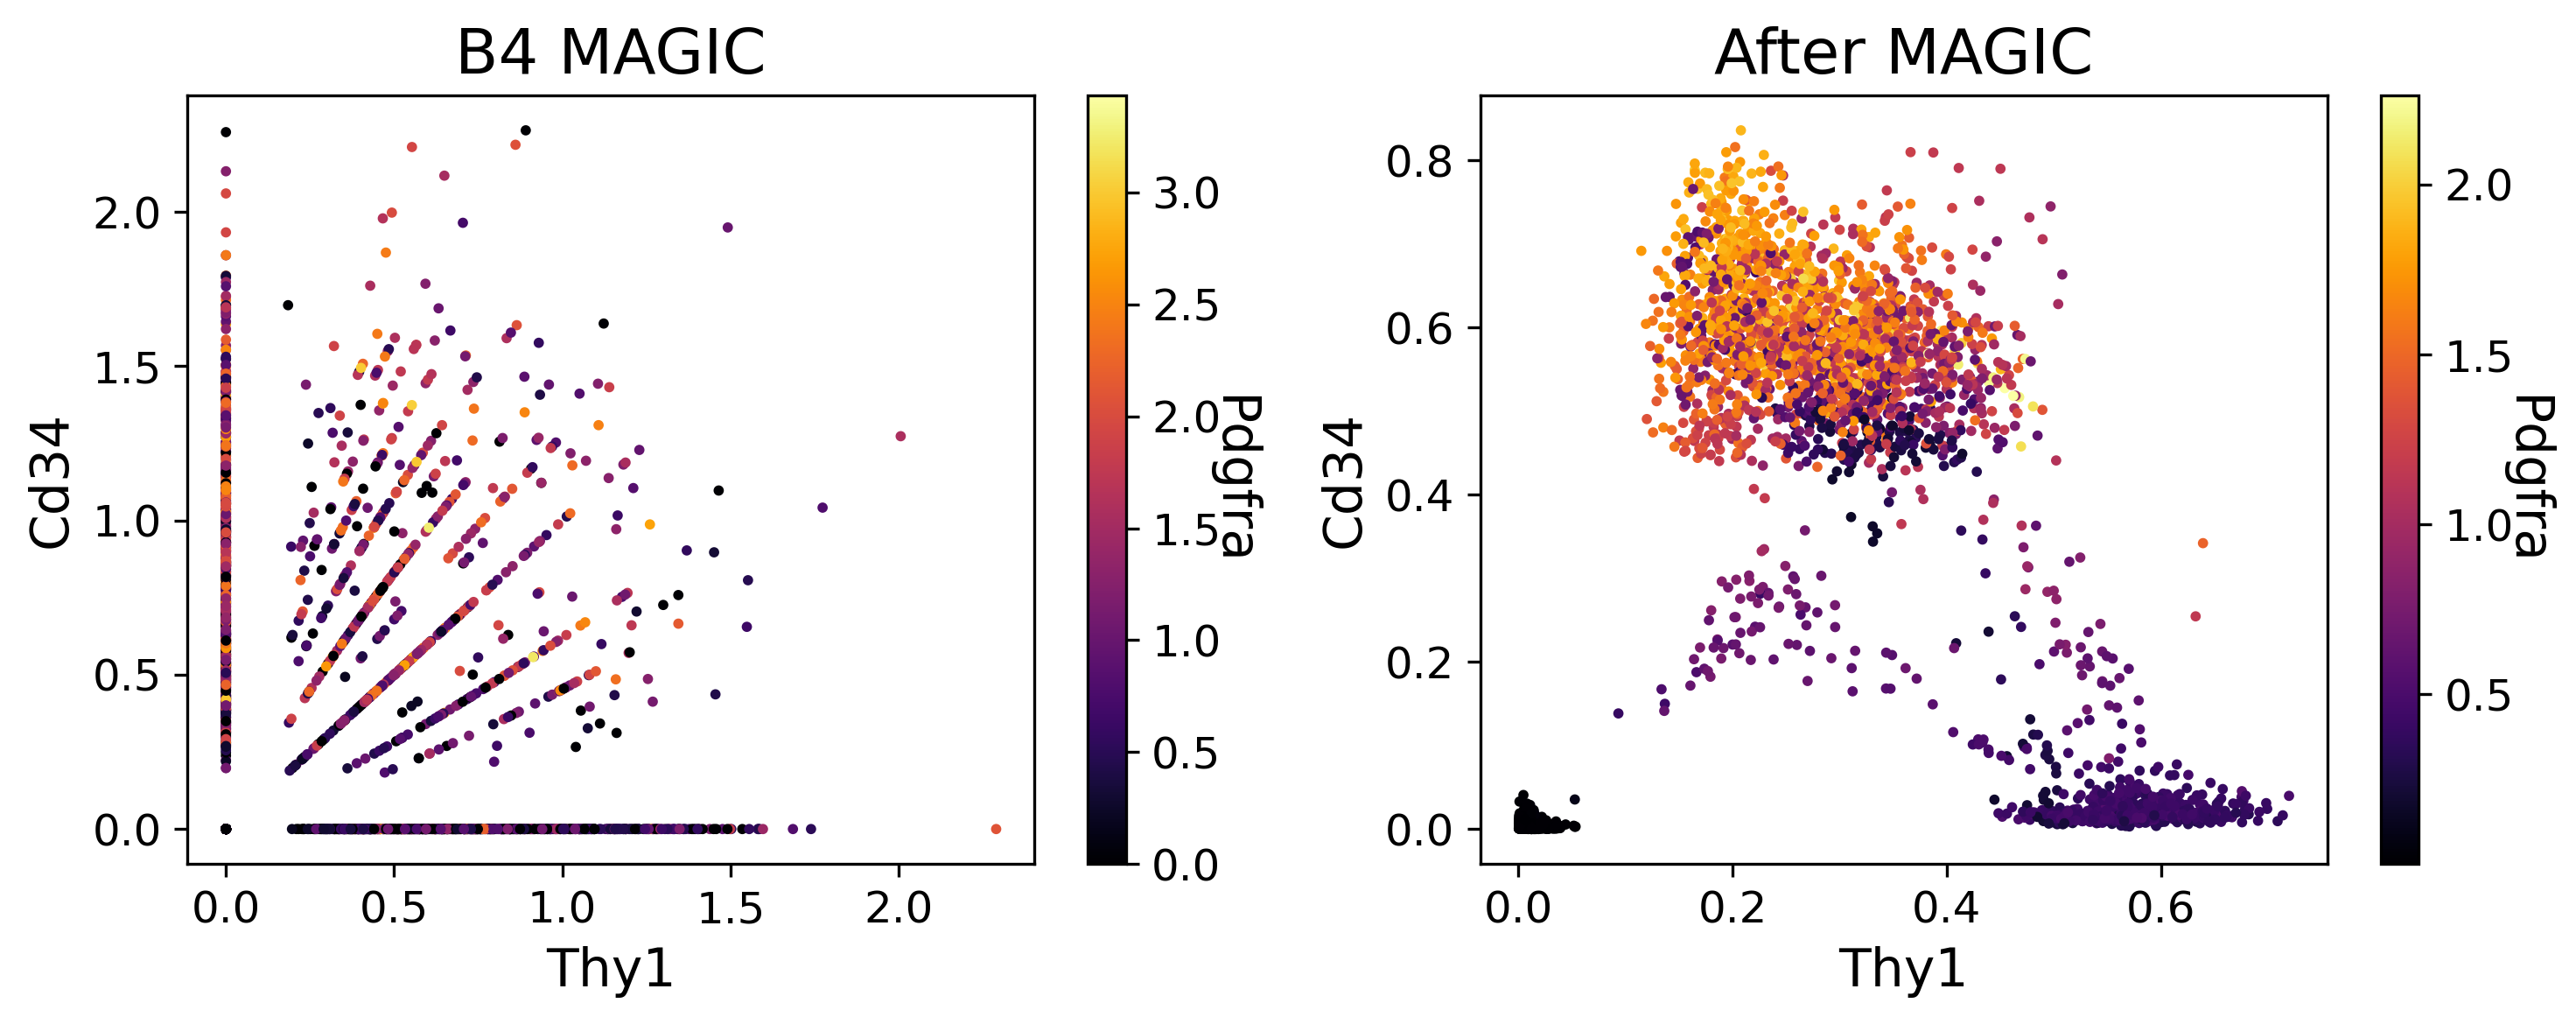

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Thy1"]], y=dRnaSeq_filt[mouse2human["Cd34"]], 
    c=dRnaSeq_filt[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Thy1"]], y=dMagicRnaSeq[mouse2human["Cd34"]], 
    c=dMagicRnaSeq[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [23]:
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
del dMagicRnaSeq
dScalRnaSeq

,A1CF,A3GALT2,A4GALT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
WT__AAACCCACAGCTTCCT-1,0.000000e+00,8.929922e-08,2.028006e-04,0.000028,0.000023,0.000000e+00,0.000032,0.000059,0.000095,0.000292,...,0.000039,1.087150e-05,0.000017,1.967455e-06,0.000132,0.000029,0.000031,0.000141,0.000034,0.000115
WT__AAACCCAGTTCGAGCC-1,0.000000e+00,9.742421e-08,1.762916e-04,0.000038,0.000024,0.000000e+00,0.000040,0.000061,0.000090,0.000291,...,0.000034,1.030478e-05,0.000016,1.466102e-05,0.000126,0.000029,0.000024,0.000145,0.000027,0.000104
WT__AAACGAAAGAAGGATG-1,0.000000e+00,6.824001e-08,1.775780e-04,0.000027,0.000031,0.000000e+00,0.000033,0.000058,0.000090,0.000311,...,0.000038,5.576223e-06,0.000026,1.447704e-06,0.000146,0.000033,0.000029,0.000155,0.000025,0.000092
WT__AAACGAAAGGAAAGGT-1,7.708612e-05,0.000000e+00,6.520701e-07,0.000004,0.000012,2.324339e-06,0.000053,0.000032,0.000170,0.000140,...,0.000034,2.055380e-07,0.000005,0.000000e+00,0.000107,0.000011,0.000029,0.000074,0.000051,0.000024
WT__AAACGAAAGTTAACGA-1,1.112760e-05,0.000000e+00,1.973654e-06,0.000017,0.000036,9.120502e-07,0.000036,0.000021,0.000135,0.000194,...,0.000024,5.218458e-06,0.000011,1.237267e-06,0.000212,0.000011,0.000010,0.000061,0.000032,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.212763e-06,0.000000e+00,3.031664e-06,0.000018,0.000017,0.000000e+00,0.000037,0.000064,0.000044,0.000155,...,0.000074,8.548486e-07,0.000007,1.596057e-07,0.000293,0.000044,0.000010,0.000051,0.000036,0.000034
WT__TTTGGTTTCCGTAGTA-1,0.000000e+00,4.161909e-08,2.101722e-04,0.000032,0.000027,0.000000e+00,0.000049,0.000079,0.000076,0.000270,...,0.000052,4.145806e-06,0.000025,3.308208e-06,0.000125,0.000029,0.000048,0.000149,0.000031,0.000116
WT__TTTGTTGTCGCTTGAA-1,3.073474e-05,0.000000e+00,3.983446e-06,0.000011,0.000045,9.823388e-07,0.000036,0.000027,0.000205,0.000175,...,0.000037,1.827229e-06,0.000007,9.478488e-09,0.000145,0.000011,0.000020,0.000048,0.000044,0.000026
WT__TTTGTTGTCTGAATCG-1,1.050138e-07,1.654415e-07,1.964145e-04,0.000022,0.000020,3.257031e-08,0.000029,0.000062,0.000142,0.000298,...,0.000025,7.942500e-06,0.000024,7.944282e-07,0.000238,0.000014,0.000024,0.000176,0.000038,0.000056


# Wavelet dictionaries

## Wavelets on KG

From the gene-gene KG get a wavelet dictionary at multiscales based on gene expression.
The resulting gene**X**wavelet matrix can be multiplied against a gene**X**cell matrix (from scRNA-seq data) in order to project the cells onto the wavelets.

This approach should be able to incorporate proteomic data from CyTOF too, as PTMs will also be nodes on the graph and we will work with a node**X**wavelet matrix.

### Compute wavelets

First convert the current networkx graph (for now the 1st component) into a pygsp Graph.
That object can then be used by the wavelet code.

1- Using [networkx](https://networkx.org/documentation/stable/install.html) package.

    - From the integrated database, we've made a pandas dataframe that has only the 
    source and target columns and then use that to make a NetworkX Graph object 
    with `from_pandas_edgelist`

In [24]:
print(pygsp.__version__)

pyG = pygsp.graphs.Graph(W=networkx.to_numpy_array(G))
pyG

0.5.1


2022-10-05 19:03:07,672:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [25]:
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=4) #J is the scale param. Confirmed
wavloc.FlattenAndNormalize()
wavloc.FlatWaves.shape

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:26<00:00, 13.27s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


(13153, 52612)

Resulting object, accessed via .FlatWaves, is a gene**X**wavelet matrix

In [26]:
fuckers = [i for i in dScalRnaSeq.columns if i not in G.nodes()]

fuckers


[]

In [27]:
wavloc.FlatWaves

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.01186148e-05, -9.54378655e-05, -9.98593864e-05],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.33903592e-04, -1.42179143e-04, -8.85052081e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -4.88179683e-05, -1.26910971e-04,  9.46981595e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.22569860e-01, -2.53891487e-06, -1.43989683e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.53275596e-06,  4.22241416e-01, -1.66709424e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.80518295e-07, -9.05871617e-07,  2.59023949e-01]])

### Project cells on geneXwavelet matrix

To project the cells on the gene**X**wavelet matrix we will multiply a cell**X**gene matrix by the gene**X**wavelet matrix, resulting in a cell**X**wavelet matrix

In [28]:
#Reorder GEX data based on adjacency matrix
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=list(G.nodes())
                )
dScalRnaSeq

,CXCL16,CXCR6,CX3CL1,CX3CR1,CCL28,CCR10,CCL27,IL6,IL6ST,IL6R,...,TRAV12-2,CEBPZOS,INAFM2,CFAP99,ANKRD62,AK4P3,SMIM29,TOGARAM2,PCNX2,C1QTNF12
WT__AAACCCACAGCTTCCT-1,0.000140,1.314603e-09,6.025582e-05,0.000000e+00,4.317113e-07,2.639975e-07,0.000091,2.495531e-05,0.000127,1.045824e-05,...,0.000000e+00,0.000274,0.000009,1.653922e-08,2.887481e-05,1.429014e-06,0.000105,2.076831e-07,4.499217e-06,1.181838e-04
WT__AAACCCAGTTCGAGCC-1,0.000130,9.199295e-09,4.262726e-05,1.556032e-07,1.687404e-07,3.742884e-07,0.000082,2.583436e-05,0.000123,1.480907e-05,...,0.000000e+00,0.000272,0.000008,0.000000e+00,3.268379e-05,4.387006e-07,0.000096,4.374911e-07,4.098261e-06,1.161362e-04
WT__AAACGAAAGAAGGATG-1,0.000175,1.944784e-09,6.162229e-05,0.000000e+00,1.457326e-07,1.016322e-06,0.000085,3.558228e-05,0.000112,6.313654e-06,...,0.000000e+00,0.000280,0.000010,2.530229e-07,2.297289e-05,3.062469e-06,0.000113,2.218828e-07,4.375654e-06,1.247145e-04
WT__AAACGAAAGGAAAGGT-1,0.000434,0.000000e+00,2.578727e-05,0.000000e+00,4.344082e-06,5.315988e-08,0.000048,0.000000e+00,0.000002,2.957699e-08,...,2.592425e-06,0.000252,0.000013,0.000000e+00,9.204649e-08,1.233042e-05,0.000158,0.000000e+00,0.000000e+00,4.455906e-07
WT__AAACGAAAGTTAACGA-1,0.000402,0.000000e+00,1.445199e-05,0.000000e+00,6.982789e-07,1.735402e-08,0.000031,5.511946e-08,0.000007,2.292222e-06,...,1.845778e-06,0.000364,0.000010,0.000000e+00,1.586445e-06,2.776788e-05,0.000145,0.000000e+00,7.179645e-09,3.165789e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000451,0.000000e+00,7.299451e-07,0.000000e+00,9.016434e-08,9.150452e-08,0.000046,1.405659e-07,0.000004,5.976831e-08,...,2.406949e-09,0.000198,0.000009,0.000000e+00,3.419864e-06,4.661570e-05,0.000282,0.000000e+00,0.000000e+00,5.195330e-06
WT__TTTGGTTTCCGTAGTA-1,0.000141,0.000000e+00,1.079783e-04,0.000000e+00,1.714585e-07,2.368089e-08,0.000087,1.917544e-05,0.000139,1.046501e-05,...,0.000000e+00,0.000257,0.000016,1.144487e-08,2.262392e-05,2.692807e-06,0.000087,3.762208e-07,4.244540e-06,1.197422e-04
WT__TTTGTTGTCGCTTGAA-1,0.000406,0.000000e+00,1.348188e-05,0.000000e+00,1.855502e-06,3.213683e-07,0.000042,0.000000e+00,0.000009,1.143117e-06,...,1.329125e-06,0.000285,0.000014,0.000000e+00,1.901037e-06,2.644862e-05,0.000150,0.000000e+00,0.000000e+00,4.722244e-06
WT__TTTGTTGTCTGAATCG-1,0.000040,2.486743e-07,4.412397e-05,5.555792e-07,4.953861e-08,1.078058e-06,0.000067,3.185084e-05,0.000076,1.987703e-05,...,1.220320e-08,0.000270,0.000008,2.486481e-09,1.586893e-05,1.004745e-05,0.000158,0.000000e+00,2.469635e-07,3.189857e-05


In [30]:
#Multiply 2 matrices using the dot product
cell_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
cell_projection.shape #Shape should be 3.7k rows by 50k columns

(3698, 52612)

This is essentially a cell-cell graph based on their differences on the comns KG. 
We can thus use this to get some phate embeddings or any other downstream steps.

In [31]:
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cell_projection_nnKGwav.npz", cell_projection)

In [32]:
cell_projection = np.load(f"{data_dir}/cell_projection_nnKGwav.npz")["arr_0"]#Dict-like struct.Default arr_N keys
cell_projection.shape 

(3698, 52612)

### Downstream 

#### Embed projections on PHATE

In [33]:
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(cell_projection) 

Calculating PHATE...
  Running PHATE on 3698 observations and 52612 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 5.81 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.75 seconds.
  Calculated landmark operator in 3.52 seconds.
  Calculating optimal t...
    Automatically selected t = 37
  Calculated optimal t in 1.29 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.38 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.01 seconds.
Calculated PHATE in 15.01 seconds.


In [34]:
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dScalRnaSeq.index, columns=["PHATE1","PHATE2"])
dCellEmbeddings

(3698, 2)


,PHATE1,PHATE2
WT__AAACCCACAGCTTCCT-1,-0.015758,-0.002384
WT__AAACCCAGTTCGAGCC-1,-0.015689,-0.006801
WT__AAACGAAAGAAGGATG-1,-0.015708,-0.003000
WT__AAACGAAAGGAAAGGT-1,0.028235,0.007575
WT__AAACGAAAGTTAACGA-1,0.033984,-0.001165
...,...,...
WT__TTTGGTTTCATTCTTG-1,0.029792,0.000985
WT__TTTGGTTTCCGTAGTA-1,-0.015203,0.000654
WT__TTTGTTGTCGCTTGAA-1,0.032043,0.003695
WT__TTTGTTGTCTGAATCG-1,-0.009955,0.012446


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

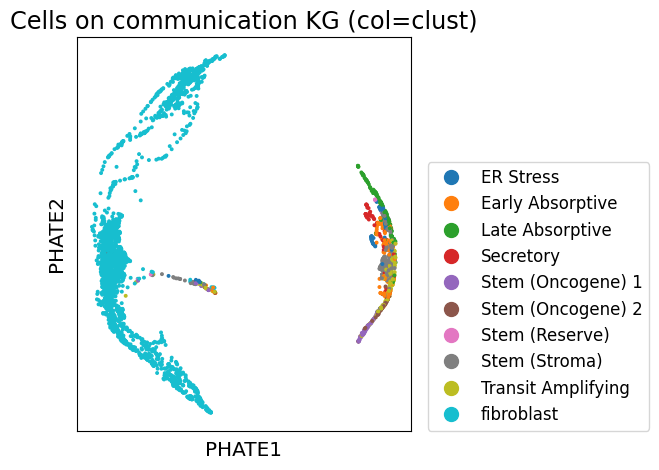

In [35]:
scprep.plot.scatter2d(
    dCellEmbeddings, c=adRnaSeq.obs.finalPOPS,
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

##### Results

Using the wavelet approach we get a very similar PHATE space as that from the DEMD approach. 

Before continuing further we should explore some kind of tunning of the KG, perhaps aiminig to *sparsify* it?

## Rmv objects from mem

In [36]:
del cell_projection
del wavloc
del pyG

## Wavelets on KGE

From the KGE 50 dim space, get a wavelet dictionary at multiscales based on gene expression.
The resulting gene**X**wavelet matrix can be multiplied against a gene**X**cell matrix (from scRNA-seq data) in order to project the cells onto the wavelets.

As before, this approach should be able to incorporate proteomic data from CyTOF too, as PTMs will also be nodes on the graph and we will work with a node**X**wavelet matrix.

The main difference with the above section will be that instead of using directly the graph object from the KG, we will load in the KGE made with the transE model in pykeen and use that to compute a knn graph between the genes/nodes.

In [37]:
dKGEnn_50filt

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A1CF,0.012249,0.097411,0.089748,-0.107028,0.042079,-0.015802,-0.015080,-0.035531,-0.108423,0.396735,...,0.109560,-0.146671,0.138407,0.118278,-0.090030,-0.198067,-0.064056,0.112160,-0.157560,0.070585
A3GALT2,0.123363,0.199229,0.271609,-0.132608,0.172234,-0.090492,-0.166408,-0.093735,0.181766,-0.114691,...,0.106843,-0.124702,0.051940,-0.014271,0.152349,-0.108898,-0.020255,0.056009,-0.145056,0.094949
A4GALT,-0.052929,0.137097,-0.211624,-0.069519,0.016974,0.057879,-0.073838,-0.051927,-0.232719,-0.044692,...,0.167424,-0.045477,0.047147,0.053376,0.176728,0.133997,-0.109465,0.038403,0.231763,0.064032
AAAS,0.101379,-0.005884,-0.133422,-0.125839,-0.062446,0.093080,0.157763,-0.162289,-0.307613,-0.035892,...,0.084470,-0.005313,-0.087076,0.193546,0.015132,-0.043238,-0.142561,0.099512,0.140596,-0.086491
AACS,0.097514,0.103843,-0.340407,-0.075971,-0.006027,0.150927,0.070135,-0.107855,-0.299987,-0.094324,...,0.089976,-0.250608,-0.086120,0.057429,0.175717,0.122928,-0.029554,-0.281542,0.100334,0.099323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.076302,-0.015164,-0.115436,-0.096460,0.133228,-0.209999,-0.033556,-0.329009,0.103920,0.014918,...,-0.111386,0.156799,0.009587,-0.206967,-0.063876,0.073380,0.021265,-0.000862,-0.002570,-0.173850
ZYG11B,0.154281,0.013954,-0.161645,-0.170701,0.077110,0.007194,0.163640,0.013357,0.084101,-0.117073,...,0.051953,-0.137357,-0.201208,0.120000,-0.147011,0.176326,-0.140640,0.019583,-0.134760,-0.269244
ZYX,0.168261,0.047865,-0.021720,-0.076904,-0.110663,0.096434,0.134658,-0.113244,0.069367,0.069998,...,0.089988,-0.037320,-0.318342,0.089743,0.215972,0.183160,-0.249219,0.011088,0.176135,-0.244414
ZZEF1,-0.587509,0.074710,-0.146124,0.098394,-0.006699,0.052911,-0.004144,-0.310832,0.171271,0.067289,...,-0.024145,0.191872,0.026109,0.103047,0.075540,0.109647,0.108737,-0.114406,-0.031095,-0.060478


In [38]:
knnKGE = sklearn.neighbors.kneighbors_graph(
    dKGEnn_50filt, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGE.toarray())
knnKGE = pygsp.graphs.Graph(W=knnKGE)
knnKGE

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [39]:
#TRy sparsified version of graph
KGEwavloc = Localizer(knnKGE) #Takes only pygsp graphs
KGEwavloc.CalculateWavelets(J=4) #J is the scale param. Confirmed
KGEwavloc.FlattenAndNormalize()
KGEwavloc.FlatWaves.shape

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:24<00:00, 12.28s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


(13153, 52612)

To project the cells on the gene**X**wavelet matrix we will multiply a cell**X**gene matrix by the gene**X**wavelet matrix, resulting in a cell**X**wavelet matrix

In [41]:
#Reorder GEX data based on adjacency matrix
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=dKGEnn_50filt.index)

dScalRnaSeq

,A1CF,A3GALT2,A4GALT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
WT__AAACCCACAGCTTCCT-1,0.000000e+00,8.929922e-08,2.028006e-04,0.000028,0.000023,0.000000e+00,0.000032,0.000059,0.000095,0.000292,...,0.000039,1.087150e-05,0.000017,1.967455e-06,0.000132,0.000029,0.000031,0.000141,0.000034,0.000115
WT__AAACCCAGTTCGAGCC-1,0.000000e+00,9.742421e-08,1.762916e-04,0.000038,0.000024,0.000000e+00,0.000040,0.000061,0.000090,0.000291,...,0.000034,1.030478e-05,0.000016,1.466102e-05,0.000126,0.000029,0.000024,0.000145,0.000027,0.000104
WT__AAACGAAAGAAGGATG-1,0.000000e+00,6.824001e-08,1.775780e-04,0.000027,0.000031,0.000000e+00,0.000033,0.000058,0.000090,0.000311,...,0.000038,5.576223e-06,0.000026,1.447704e-06,0.000146,0.000033,0.000029,0.000155,0.000025,0.000092
WT__AAACGAAAGGAAAGGT-1,7.708612e-05,0.000000e+00,6.520701e-07,0.000004,0.000012,2.324339e-06,0.000053,0.000032,0.000170,0.000140,...,0.000034,2.055380e-07,0.000005,0.000000e+00,0.000107,0.000011,0.000029,0.000074,0.000051,0.000024
WT__AAACGAAAGTTAACGA-1,1.112760e-05,0.000000e+00,1.973654e-06,0.000017,0.000036,9.120502e-07,0.000036,0.000021,0.000135,0.000194,...,0.000024,5.218458e-06,0.000011,1.237267e-06,0.000212,0.000011,0.000010,0.000061,0.000032,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.212763e-06,0.000000e+00,3.031664e-06,0.000018,0.000017,0.000000e+00,0.000037,0.000064,0.000044,0.000155,...,0.000074,8.548486e-07,0.000007,1.596057e-07,0.000293,0.000044,0.000010,0.000051,0.000036,0.000034
WT__TTTGGTTTCCGTAGTA-1,0.000000e+00,4.161909e-08,2.101722e-04,0.000032,0.000027,0.000000e+00,0.000049,0.000079,0.000076,0.000270,...,0.000052,4.145806e-06,0.000025,3.308208e-06,0.000125,0.000029,0.000048,0.000149,0.000031,0.000116
WT__TTTGTTGTCGCTTGAA-1,3.073474e-05,0.000000e+00,3.983446e-06,0.000011,0.000045,9.823388e-07,0.000036,0.000027,0.000205,0.000175,...,0.000037,1.827229e-06,0.000007,9.478488e-09,0.000145,0.000011,0.000020,0.000048,0.000044,0.000026
WT__TTTGTTGTCTGAATCG-1,1.050138e-07,1.654415e-07,1.964145e-04,0.000022,0.000020,3.257031e-08,0.000029,0.000062,0.000142,0.000298,...,0.000025,7.942500e-06,0.000024,7.944282e-07,0.000238,0.000014,0.000024,0.000176,0.000038,0.000056


In [42]:
# #Multiply 2 matrices using the dot product
cellKGE_projection = np.dot(dScalRnaSeq, KGEwavloc.FlatWaves)
print(cellKGE_projection.shape)
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cellKGE_projection_nnKGEwav.npz", cellKGE_projection)

In [43]:
del KGEwavloc
cellKGE_projection = np.load(f"{data_dir}/cellKGE_projection_nnKGEwav.npz")["arr_0"]#Dict-like struct.Default arr_N keys
print(cellKGE_projection.shape)
#Embed in PHATE
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(cellKGE_projection)
dCellEmbeddings_wavKGE = pd.DataFrame(data=data_phate, index = dScalRnaSeq.index, columns=["PHATE1","PHATE2"])
del cellKGE_projection
del phate_op
del data_phate

(3698, 52612)
Calculating PHATE...
  Running PHATE on 3698 observations and 52612 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 5.69 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.11 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.72 seconds.
  Calculated landmark operator in 3.44 seconds.
  Calculating optimal t...
    Automatically selected t = 50
  Calculated optimal t in 1.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.98 seconds.
Calculated PHATE in 13.70 seconds.


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Cells on communication wavKGE (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

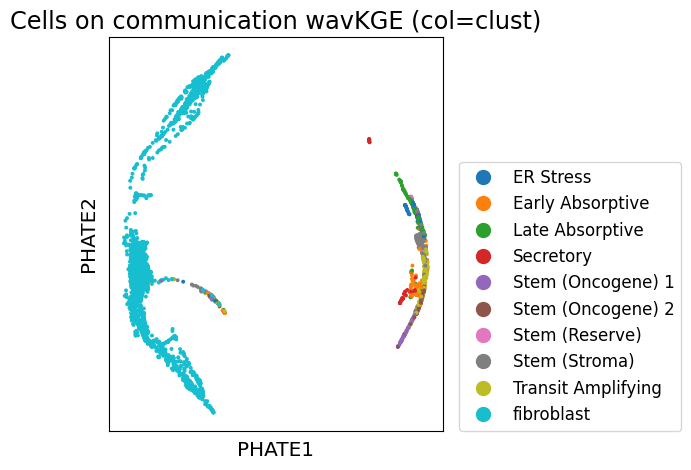

In [44]:
scprep.plot.scatter2d(
    dCellEmbeddings_wavKGE, c=adRnaSeq.obs.finalPOPS,
    title="Cells on communication wavKGE (col=clust)", ticks=None,
    legend_loc=(1.05, 0))